Starting video encoding...


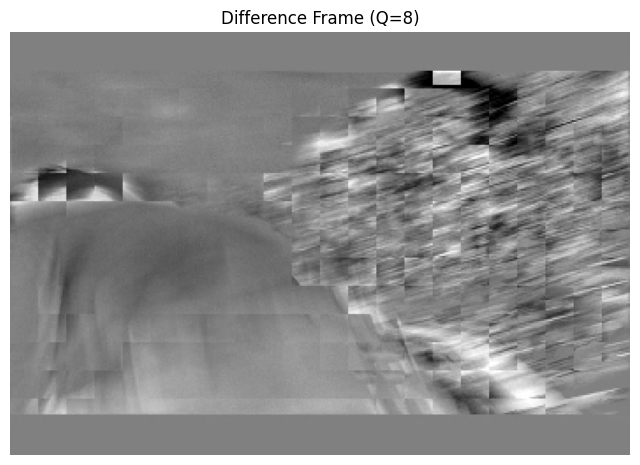

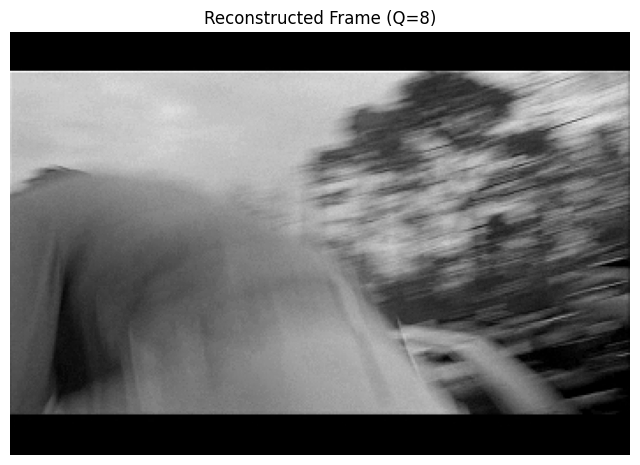

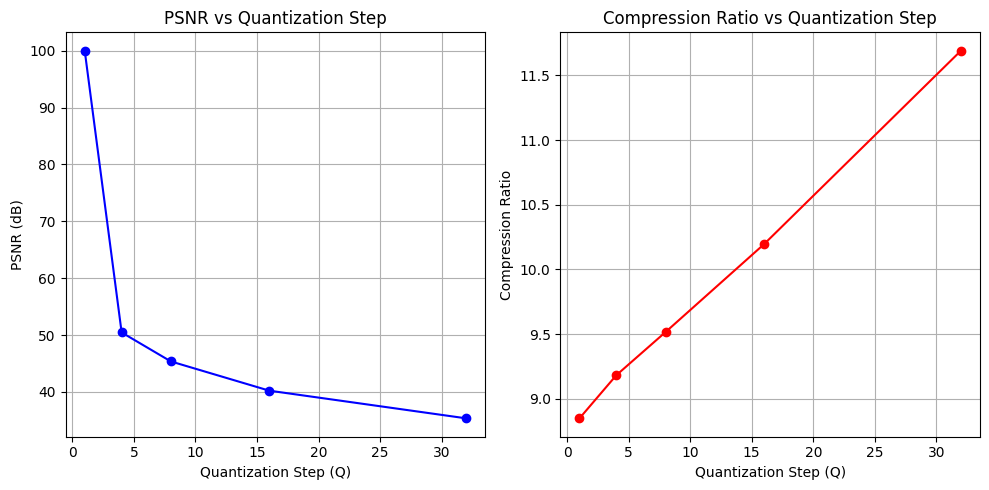

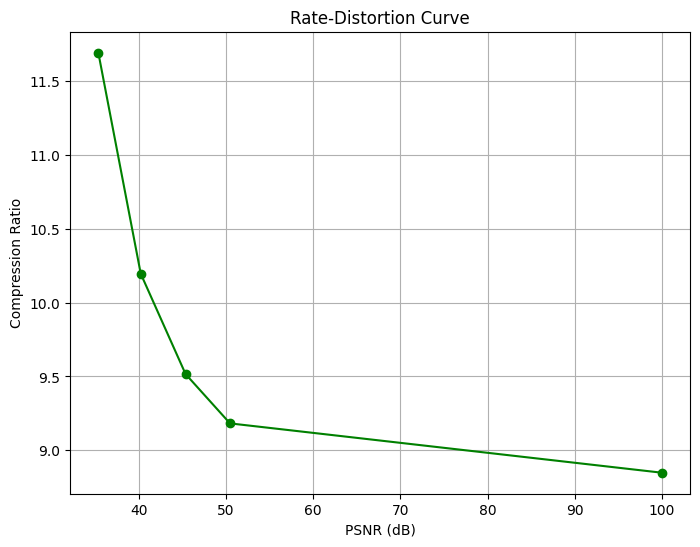


Encoding Results:
Q	PSNR (dB)	Compression Ratio
----------------------------------------
1	100.00		8.85
4	50.45		9.18
8	45.36		9.52
16	40.22		10.20
32	35.35		11.69


In [2]:
import av
import numpy as np
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger(__name__)

class VideoCodec:
    def __init__(self, block_size=16, search_radius=8):
        self.block_size = block_size
        self.search_radius = search_radius
        
    def read_video(self, input_path):
        """Read video file and extract Y component frames"""
        try:
            container = av.open(input_path)
            frames = []
            total_frames = container.streams.video[0].frames
            logger.info(f"Reading {total_frames} frames...")
            
            for i, frame in enumerate(container.decode(video=0)):
                # Convert frame to numpy array in grayscale format
                img = frame.to_ndarray(format='gray')
                # Ensure correct data type
                img = img.astype(np.float32)
                frames.append(img)
                
                # Log progress
                if i % 10 == 0:
                    logger.info(f"Processed {i}/{total_frames} frames")
            
            logger.info("Video reading completed")
            return frames
            
        except Exception as e:
            logger.error(f"Error reading video: {str(e)}")
            raise
    
    def logarithmic_search(self, curr_block, ref_frame, x, y):
        """Logarithmic search for motion estimation"""
        best_x, best_y = x, y
        best_sat = float('inf')
        step = self.search_radius
        
        while step >= 1:
            for dx in [-step, 0, step]:
                for dy in [-step, 0, step]:
                    new_x = x + dx
                    new_y = y + dy
                    
                    if (new_x < 0 or new_x + self.block_size > ref_frame.shape[1] or
                        new_y < 0 or new_y + self.block_size > ref_frame.shape[0]):
                        continue
                        
                    ref_block = ref_frame[new_y:new_y+self.block_size, 
                                        new_x:new_x+self.block_size]
                    sat = np.sum(np.abs(curr_block - ref_block))
                    
                    if sat < best_sat:
                        best_sat = sat
                        best_x = new_x
                        best_y = new_y
            
            step //= 2
            
        return best_x - x, best_y - y
    
    def motion_estimation(self, curr_frame, ref_frame):
        """Perform motion estimation using logarithmic search"""
        height, width = curr_frame.shape
        mv_x = np.zeros((height//self.block_size, width//self.block_size))
        mv_y = np.zeros((height//self.block_size, width//self.block_size))
        
        for i in range(0, height-self.block_size+1, self.block_size):
            for j in range(0, width-self.block_size+1, self.block_size):
                curr_block = curr_frame[i:i+self.block_size, j:j+self.block_size]
                dx, dy = self.logarithmic_search(curr_block, ref_frame, j, i)
                mv_x[i//self.block_size, j//self.block_size] = dx
                mv_y[i//self.block_size, j//self.block_size] = dy
                
        return mv_x, mv_y
    
    def motion_compensation(self, ref_frame, mv_x, mv_y):
        """Perform motion compensation using motion vectors"""
        height, width = ref_frame.shape
        compensated = np.zeros_like(ref_frame)
        
        for i in range(mv_x.shape[0]):
            for j in range(mv_x.shape[1]):
                ref_x = j * self.block_size + int(mv_x[i, j])
                ref_y = i * self.block_size + int(mv_y[i, j])
                
                if (ref_x >= 0 and ref_x + self.block_size <= width and
                    ref_y >= 0 and ref_y + self.block_size <= height):
                    compensated[i*self.block_size:(i+1)*self.block_size,
                            j*self.block_size:(j+1)*self.block_size] = \
                        ref_frame[ref_y:ref_y+self.block_size,
                                ref_x:ref_x+self.block_size]
                        
        return compensated
    
    def quantize(self, data, Q):
        """Quantize the data with step size Q"""
        return np.round(data / Q) * Q
    
    def compute_psnr(self, original, compressed):
        """Compute PSNR between original and compressed frames"""
        mse = np.mean((original - compressed) ** 2)
        if mse < 1e-10:  # Используем малое пороговое значение вместо 0
            return 100.0  # Возвращаем большое, но конечное значение PSNR
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr

    def encode_video(self, input_path, q_values):
        """Encode video with different quantization steps"""
        frames = self.read_video(input_path)
        results = []
        
        for Q in q_values:
            logger.info(f"Processing with quantization step Q={Q}")
            psnr_values = []
            compression_ratios = []
            diff_frames = []
            reconstructed_frames = []
            
            for i in range(1, len(frames)):
                # Motion estimation
                mv_x, mv_y = self.motion_estimation(frames[i], frames[i-1])
                
                # Motion compensation
                predicted = self.motion_compensation(frames[i-1], mv_x, mv_y)
                
                # Residual
                residual = frames[i] - predicted
                
                # Quantization с масштабированием
                scaled_residual = residual / 255.0  # Нормализация
                quantized_residual = self.quantize(scaled_residual, Q/255.0)  # Квантование в нормализованном пространстве
                residual_reconstructed = quantized_residual * 255.0  # Возврат к исходному масштабу
                
                # Reconstruction
                reconstructed = predicted + residual_reconstructed
                reconstructed = np.clip(reconstructed, 0, 255)
                
                # Calculate metrics
                psnr = self.compute_psnr(frames[i], reconstructed)
                psnr_values.append(psnr)
                
                # Store frames
                diff_frames.append(residual)
                reconstructed_frames.append(reconstructed)
                
                # Estimate compression ratio
                orig_size = frames[i].size * 8
                # Учитываем векторы движения и ненулевые коэффициенты после квантования
                mv_bits = (mv_x.size + mv_y.size) * 8
                residual_bits = np.count_nonzero(quantized_residual) * 8
                compressed_size = mv_bits + residual_bits
                compression_ratio = orig_size / (compressed_size + 1)  # +1 чтобы избежать деления на 0
                compression_ratios.append(compression_ratio)
                
                # Log progress
                if i % 10 == 0:
                    logger.info(f"Processed frame {i}/{len(frames)-1} for Q={Q}")
                    logger.info(f"Current PSNR: {psnr:.2f} dB")
                    logger.info(f"Current Compression Ratio: {compression_ratio:.2f}")
            
            results.append({
                'Q': Q,
                'psnr': np.mean(psnr_values),
                'compression_ratio': np.mean(compression_ratios),
                'diff_frames': diff_frames,
                'reconstructed_frames': reconstructed_frames
            })
        
        return results
        
    def plot_results(self, results):
        """Plot PSNR and compression ratio graphs"""
        q_values = [r['Q'] for r in results]
        psnr_values = [r['psnr'] for r in results]
        cr_values = [r['compression_ratio'] for r in results]
        
        # PSNR vs Q
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(q_values, psnr_values, 'b-o')
        plt.xlabel('Quantization Step (Q)')
        plt.ylabel('PSNR (dB)')
        plt.title('PSNR vs Quantization Step')
        plt.grid(True)
        
        # Compression Ratio vs Q
        plt.subplot(1, 2, 2)
        plt.plot(q_values, cr_values, 'r-o')
        plt.xlabel('Quantization Step (Q)')
        plt.ylabel('Compression Ratio')
        plt.title('Compression Ratio vs Quantization Step')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Compression Ratio vs PSNR
        plt.figure(figsize=(8, 6))
        plt.plot(psnr_values, cr_values, 'g-o')
        plt.xlabel('PSNR (dB)')
        plt.ylabel('Compression Ratio')
        plt.title('Rate-Distortion Curve')
        plt.grid(True)
        plt.show()

def display_frame(title, frame):
    """Helper function to display frames"""
    plt.figure(figsize=(8, 6))
    plt.imshow(frame, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def main():
    # Initialize codec
    codec = VideoCodec(block_size=16, search_radius=8)
    
    # Input video path - replace with your video path
    input_path = "lr1_1.AVI"
    
    # Define quantization steps
    q_values = [1, 4, 8, 16, 32]
    
    print("Starting video encoding...")
    
    # Encode video
    results = codec.encode_video(input_path, q_values)
    
    # Display example frames from the middle of the sequence for Q=8
    middle_result = next(r for r in results if r['Q'] == 8)
    middle_frame_idx = len(middle_result['diff_frames']) // 2
    
    # Display difference frame
    diff_frame = middle_result['diff_frames'][middle_frame_idx]
    # Clip and normalize for visualization
    diff_frame_vis = np.clip(diff_frame + 128, 0, 255).astype(np.uint8)
    display_frame(f"Difference Frame (Q=8)", diff_frame_vis)
    
    # Display reconstructed frame
    reconstructed_frame = middle_result['reconstructed_frames'][middle_frame_idx]
    display_frame(f"Reconstructed Frame (Q=8)", reconstructed_frame)
    
    # Plot results
    codec.plot_results(results)
    
    # Print metrics
    print("\nEncoding Results:")
    print("Q\tPSNR (dB)\tCompression Ratio")
    print("-" * 40)
    for result in results:
        print(f"{result['Q']}\t{result['psnr']:.2f}\t\t{result['compression_ratio']:.2f}")

if __name__ == "__main__":
    main()